# Project 6: IMDB

This project involves NLP, decision trees, bagging, boosting, and more!

---

## Load packages

You are likely going to need to install the `imdbpie` package:

    > pip install imdbpie

---

In [2]:
import os
import subprocess
import collections
import re
import csv
import json

import pandas as pd
import numpy as np
import scipy

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV

import psycopg2
from sqlalchemy import create_engine
import requests
from imdbpie import Imdb
import nltk

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

---

## Part 1: Acquire the Data

You will connect to the IMDB API to query for movies. 

See here for documentation on how to use the package:

https://github.com/richardasaurus/imdb-pie

#### 1. Connect to the IMDB API

In [2]:
imdb = Imdb()
imdb = Imdb(anonymize=True)
top_250 = pd.DataFrame(imdb.top_250())

#### 2. Query the top 250 rated movies in the database

In [ ]:
top_250 = top_250.sort_values(by='rating', ascending=False)

#### 3. Make a dataframe from the movie data

Keep the fields:

    num_votes
    rating
    tconst
    title
    year
    
And discard the rest

In [ ]:
mask = ['num_votes', 'rating', 'tconst', 'title', 'year']
top_100 = top_100[mask]
top_250 = top_250.sort_values(by='rating', ascending=False)

#### 3. Select only the top 100 movies

In [ ]:
top_100 = top_250[0:100]

#### 4. Get the genres and runtime for each movie and add them to the dataframe

There can be multiple genres per movie, so this will need some finessing.

In [ ]:
top_100
movie_list = top_100['tconst']

def get_genre_runtime(b):
    genres = []
    runtime = []
    for i in b:
        request = requests.get('http://www.omdbapi.com/?i='+i+'&plot=short&r=json')
        r = request.json()
        genres.append(r['Genre'])
        runtime.append(r['Runtime'])
    answer =  pd.DataFrame({'genre':genres, 'runtime':runtime, 'tconst':movie_list})
    return answer

df = get_genre_runtime(movie_list)

# formatting data
df['runtime'] = df['runtime'].apply(lambda x: x.strip(' min'))
df['runtime'] = pd.to_numeric(df['runtime'])

# removing multiple genre names
def after_stripper(a):
    head, sep, tail = a.partition(',')
    return head

df['genre'] = df['genre'].apply(lambda x: after_stripper(x))

# merging values
df.reset_index(drop=True)
top_100.reset_index(drop=True)



#### 4. Write the Results to a csv

In [ ]:
top_100_clean = pd.merge(top_100, df)
top_100_clean.to_csv('top_100.csv', encoding = 'utf-8', index=False)

---

## Part 2: Wrangle the text data

#### 1. Scrape the reviews for the top 100 movies

NOTE - unable to do scraping, got reviews from the omdb api instead

In [ ]:
#read in product of above code from .csv for time and such


#### 2. Extract the reviews and the rating per review for each movie

*Note*: read in from omdb api 

In [ ]:
movie_list = pd.read_csv('top_100.csv')
movie_list = movie_list['tconst']

review_list = []
for i in movie_list:
    x = imdb.get_title_reviews(i, max_results=10000)
    review_list.append(x)
    print i


master_reviews = []
counter = 0
for i in review_list:
    imdb_value = movie_list[counter]
    for j in i:
        text = j.text
        score = j.rating
        master_reviews.append({'imdb_value':imdb_value, 'text':text, 'user_movie_score':score})
    counter +=1



#### 3. Remove the non AlphaNumeric characters from reviews

In [ ]:
len(master_reviews)
master_reviews = pd.DataFrame(master_reviews)
master_reviews['text'] = master_reviews['text'].apply(lambda x: re.sub(r'\W+', ' ', x))
master_reviews.dropna(inplace=True)
master_reviews.to_csv('reviews.csv', encoding = 'utf-8', index=False)

#### 4. Calculate the top 200 ngrams from the user reviews

Use the `TfidfVectorizer` in sklearn.

Recommended parameters:

    ngram_range = (1, 2)
    stop_words = 'english'
    binary = False
    max_features = 200

In [1]:
# reading in file from csv to not repeat the lengthy code above
reviews_final = pd.read_csv('reviews.csv')

vectorizer = TfidfVectorizer(ngram_range = (1, 2), stop_words = 'english',
                                binary = False, max_features = 200)

## Bonusish 

### stemmed reviews in an attempt to get a better accuracy scor

In [ ]:
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer

# based on http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html
# and http://stackoverflow.com/questions/26126442/combining-text-stemming-and-removal-of-punctuation-in-nltk-and-scikit-learn
# stemmer that iterates over all elements of a tokenized list
stemmer = PorterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

# incorporates above stemmer with a tokenizer function
def tokenize(text):
    tokens = word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

# instantiating vectorizer with above tokenizer/stemmer
vectorizer2 = TfidfVectorizer(tokenizer=tokenize, ngram_range = (1, 2), stop_words = 'english',
                                binary = False, max_features = 200)

vectorizer2.fit(tester['text'])
dense_matrix2 = pd.DataFrame(vectorizer2.transform(tester['text']).todense(), columns=vectorizer2.get_feature_names())


#### 5. Merge the user reviews and ratings

In [ ]:
tester = tester.join(dense_matrix2)

#### 6. Save this merged dataframe as a csv

In [ ]:
tester.to_csv('reviews_stemmed.csv', encoding = 'utf-8', index=False)

---

## Part 3: Combine Tables in PostgreSQL

NOTE: did not read into sql, just wrote to a csv... had trouble connecting 
initially and I wanted to move on

#### 1. Reading in complete dataframes anding merging into a single table


In [6]:
stemmed_reviews = pd.read_csv('reviews_stemmed.csv')
reviews = pd.read_csv('reviews_final.csv')
movies = pd.read_csv('top_100.csv')

# merging reviews with top_100 data in 2 separate dataframes
stemmed_full = pd.merge(left=stemmed_reviews, right=movies, how='left', left_on='imdb_value',right_on='tconst')
reviews_full = pd.merge(left=reviews, right=movies, how='left', left_on='imdb_value',right_on='tconst')

---

## Part 4: Parsing and Exploratory Data Analysis

#### 1. Rename any columns you think should be renamed for clarity

In [7]:
# removing extra columns
stemmed_full.pop('tconst')
reviews_full.pop('tconst')

0        tt0111161
1        tt0111161
2        tt0111161
3        tt0111161
4        tt0111161
5        tt0111161
6        tt0111161
7        tt0111161
8        tt0111161
9        tt0111161
10       tt0111161
11       tt0111161
12       tt0111161
13       tt0111161
14       tt0111161
15       tt0111161
16       tt0111161
17       tt0111161
18       tt0111161
19       tt0111161
20       tt0111161
21       tt0111161
22       tt0111161
23       tt0111161
24       tt0111161
25       tt0111161
26       tt0111161
27       tt0111161
28       tt0111161
29       tt0111161
           ...    
93219    tt0055031
93220    tt0055031
93221    tt0055031
93222    tt0055031
93223    tt0055031
93224    tt0055031
93225    tt0055031
93226    tt0055031
93227    tt0055031
93228    tt0055031
93229    tt0055031
93230    tt0055031
93231    tt0055031
93232    tt0055031
93233    tt0055031
93234    tt0055031
93235    tt0055031
93236    tt0055031
93237    tt0055031
93238    tt0055031
93239    tt0055031
93240    tt0

#### 2. Describe anything interesting or suspicious about your data (quality assurance)

there is nothing inherently suspiscious about the reviews.  We are attempting to predict extremely discrete (as well as interger on a user/user) basis in this project so the degree of accuracy will be highly incorrect most likely. 

#### 3. Make four visualizations of interest to you using the data

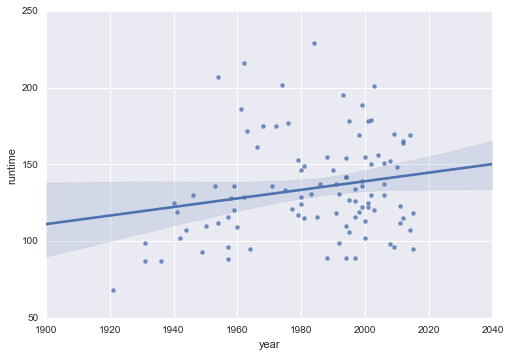

In [11]:
# runtime/year
sns.regplot(movies['year'], movies['runtime'])


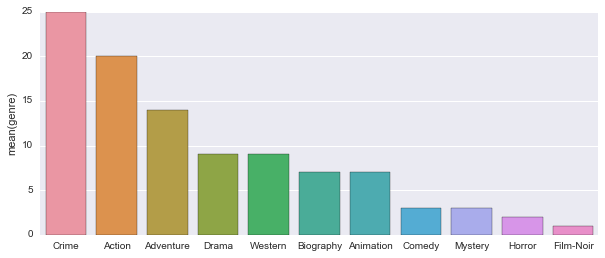

In [12]:
# barplot of genres:
labels = movies['genre'].unique()
data = movies['genre'].value_counts()
sns.barplot(x=labels, y=data)
plt.gcf().set_size_inches(10, 4)

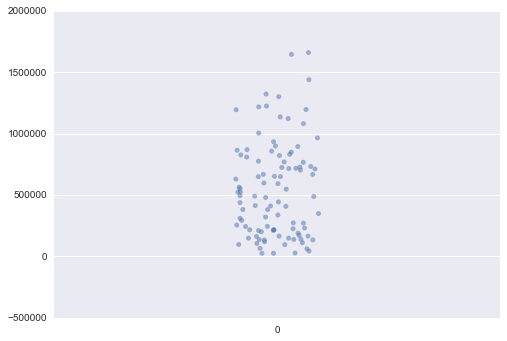

In [13]:
# total votes/movies
sns.stripplot(data= movies['num_votes'], jitter=True, alpha=.5)

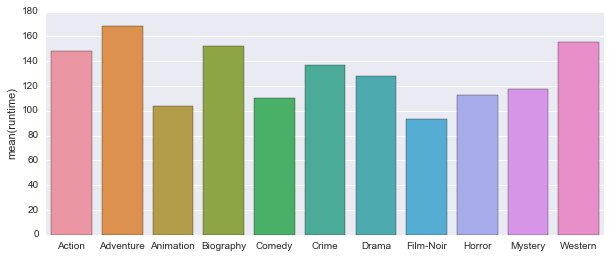

In [74]:
series = pd.DataFrame(movies.groupby(['genre'])['runtime'].mean())
labels = list(series.index)

pizza = pd.DataFrame((movies.groupby(['genre'])['runtime'].mean()))
data = pizza['runtime']
sns.barplot(x=labels, y=data)
plt.gcf().set_size_inches(10, 4)


---

## Part 5: Decision Tree Classifiers and Regressors

#### 1. What is our target attribute? 

I will be attempting to predict the user generated score of a movie based on reviews

#### 2. Prepare the X and Y matrices and preprocess data as you see fit

In [76]:
x = stemmed_full.columns
x = x[3:202]

genre_dummies = pd.DataFrame(pd.get_dummies(stemmed_full['genre']))
genre_columns=genre_dummies.columns
stemmed_full = pd.concat([stemmed_full, genre_dummies], axis=1)

x_mask = ['10', '2', 'act', 'action', 'actor', 'actual', 'alway', 'amaz',
       'american', 'ani', 'anoth', 'anyth', 'audienc', 'away', 'bad',
       'batman', 'beauti', 'becaus', 'becom', 'befor', 'begin', 'believ',
       'best', 'better', 'big', 'bit', 'book', 'brilliant', 'cast',
       'chang', 'charact', 'cinema', 'classic', 'come', 'complet', 'creat',
       'dark', 'dark knight', 'day', 'definit', 'did', 'didn', 'didn t',
       'differ', 'direct', 'director', 'doe', 'doesn', 'doesn t', 'don',
       'don t', 'dream', 'effect', 'emot', 'end', 'enjoy', 'especi',
       'everi', 'everyon', 'everyth', 'excel', 'expect', 'face', 'fact',
       'famili', 'fan', 'far', 'favorit', 'feel', 'fight', 'film', 'final',
       'follow', 'friend', 'good', 'got', 'great', 'greatest', 'guy', 'ha',
       'happen', 'hard', 'help', 'hi', 'histori', 'hope', 'hour', 'howev',
       'human', 'idea', 'job', 'joker', 'just', 'kill', 'knight', 'know',
       'leav', 'let', 'life', 'like', 'line', 'littl', 'live', 'll',
       'long', 'look', 'lot', 'love', 'm', 'make', 'man', 'mani',
       'masterpiec', 'mean', 'mind', 'minut', 'moment', 'movi', 'movi wa',
       'music', 'need', 'new', 'nolan', 'noth', 'old', 'onc', 'onli',
       'origin', 'oscar', 'peopl', 'perfect', 'perform', 'person',
       'pictur', 'place', 'play', 'plot', 'point', 'power', 'probabl',
       'quit', 'rate', 'read', 'real', 'realli', 'reason', 'review',
       'right', 'ring', 'role', 's', 'said', 'saw', 'say', 'scene',
       'screen', 'second', 'seen', 'sens', 'set', 'shot', 'simpli', 'sinc',
       'someth', 'special', 'star', 'start', 'stori', 'sure', 't', 'tell',
       'thi', 'thi film', 'thi movi', 'thing', 'think', 'thought', 'time',
       'tri', 'true', 'truli', 'turn', 'understand', 'use', 've', 'veri',
       'view', 'viewer', 'wa', 'want', 'war', 'watch', 'watch thi', 'way',
       'whi', 'wonder', 'word', 'work', 'world', 'runtime', 'year_y', 'Action',
       'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Film-Noir',
       'Horror', 'Mystery', 'Western']

x2_mask = ['10', '2', 'act', 'action', 'actor', 'actual', 'alway', 'amaz',
       'american', 'ani', 'anoth', 'anyth', 'audienc', 'away', 'bad',
       'batman', 'beauti', 'becaus', 'becom', 'befor', 'begin', 'believ',
       'best', 'better', 'big', 'bit', 'book', 'brilliant', 'cast',
       'chang', 'charact', 'cinema', 'classic', 'come', 'complet', 'creat',
       'dark', 'dark knight', 'day', 'definit', 'did', 'didn', 'didn t',
       'differ', 'direct', 'director', 'doe', 'doesn', 'doesn t', 'don',
       'don t', 'dream', 'effect', 'emot', 'end', 'enjoy', 'especi',
       'everi', 'everyon', 'everyth', 'excel', 'expect', 'face', 'fact',
       'famili', 'fan', 'far', 'favorit', 'feel', 'fight', 'film', 'final',
       'follow', 'friend', 'good', 'got', 'great', 'greatest', 'guy', 'ha',
       'happen', 'hard', 'help', 'hi', 'histori', 'hope', 'hour', 'howev',
       'human', 'idea', 'job', 'joker', 'just', 'kill', 'knight', 'know',
       'leav', 'let', 'life', 'like', 'line', 'littl', 'live', 'll',
       'long', 'look', 'lot', 'love', 'm', 'make', 'man', 'mani',
       'masterpiec', 'mean', 'mind', 'minut', 'moment', 'movi', 'movi wa',
       'music', 'need', 'new', 'nolan', 'noth', 'old', 'onc', 'onli',
       'origin', 'oscar', 'peopl', 'perfect', 'perform', 'person',
       'pictur', 'place', 'play', 'plot', 'point', 'power', 'probabl',
       'quit', 'rate', 'read', 'real', 'realli', 'reason', 'review',
       'right', 'ring', 'role', 's', 'said', 'saw', 'say', 'scene',
       'screen', 'second', 'seen', 'sens', 'set', 'shot', 'simpli', 'sinc',
       'someth', 'special', 'star', 'start', 'stori', 'sure', 't', 'tell',
       'thi', 'thi film', 'thi movi', 'thing', 'think', 'thought', 'time',
       'tri', 'true', 'truli', 'turn', 'understand', 'use', 've', 'veri',
       'view', 'viewer', 'wa', 'want', 'war', 'watch', 'watch thi', 'way',
       'whi', 'wonder', 'word', 'work', 'world', 'year_y', 'Action',
       'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Film-Noir',
       'Horror', 'Mystery', 'Western', 'user_movie_score']

# segmenting variables
y = stemmed_full['user_movie_score']
X = stemmed_full[x_mask]

#### 3. Build and cross-validate your decision tree classifier

In [ ]:
trees2 = DecisionTreeClassifier()
trees2.fit(X, y)
cross_val_score(trees2, X, y, cv=5, n_jobs=-1)

#### 4. Gridsearch optimal parameters for your classifier. Does the performance improve?

In [ ]:
grid_classifier = {'max_depth':depth, 'max_features':x}
x = range(1,200,10)
depth = [1,2,3,4,5]
trees3 = DecisionTreeClassifier()
grid = GridSearchCV(trees2, grid_classifier)
grid.fit(X,y)
grid.best_score_
# 0.52544263209256936 is my best accuracy
grid.best_params_
{'max_depth': 1, 'max_features': 1}

the performance does not improve. best_params_ = max_depth:1, max_features:1 which equates to the 

#### 5. Build and cross-validate your decision tree regressor

In [ ]:
# instantiating regressor and cross validating stuff
# regressor doesn't work for predicting these.... I ran them initially, but the score is very low
trees = DecisionTreeRegressor()
trees.fit(X, y)
cross_val_score(trees, X, y, cv=5, n_jobs=-1)

# regression attempt to predict runtime
X2 = stemmed_full[x2_mask]
y2 = stemmed_full['runtime']
trees4 = DecisionTreeRegressor()
trees4.fit(X2, y2)
cross_val_score(trees4, X2, y2, cv=5, n_jobs=-1)

#### 6. Gridsearch the optimal parameters for your classifier. Does performance improve?

the performance does not improve at the regressor is attempting to predict an interger value and using a continuous, decimal value to do so (and judges accuracy score based on this)

---

## Part 7: Bagging and Boosting: Random Forests, Extra Trees, and AdaBoost

#### 1. Load the random forest regressor, extra trees regressor, and adaboost regressor from sklearn

In [78]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier

#### 2. Gridsearch optimal parameters for the three different ensemble methods.

In [ ]:
# train test split to get accuracy score for classification models
X_train, X_test, y_train, y_test = train_test_split(X, y)



#### 3. Evaluate the performance of the two bagging and one boosting model. Which performs best?

In [80]:
# function to help do crossvalidaton

def do_cross_val(model, X, y):
    scores = cross_val_score(model, X, y, cv=5, n_jobs=-1, verbose=1)
    return scores.mean(), scores.std()

In [ ]:
# cross val scores with a bagging/decision tree classifier
bdt = BaggingClassifier()
do_cross_val(bdt)
# best score is :(0.38116005470351122, std:0.052192121705746754)


# adaboost classifer with cross cal
ada = AdaBoostClassifier()
do_cross_val(ada, X, y)
# best score with adaboost - (0.51081392284531635, std:0.024275400766445469)

#verifying the score with adaboost is not a "node"
ada.fit(X,y)
pd.DataFrame(ada.predict_proba(X_test))

# Extra Trees
x_trees = ExtraTreesClassifier()
do_cross_val(x_trees, X, y)
# Extra trees best score - (0.43864060302745989, std:0.036794626953118421)

In [84]:
# Random Forest Classification with crossval
forest = RandomForestClassifier()
do_cross_val(forest, X, y)
forest.fit(X,y)

#random forrest classifier best score - (0.45703255495422573, std: 0.027952293163319378)

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.8s finished


(0.44489289568442103, 0.036088026055851645)

#### 4. Extract the feature importances from the Random Forest regressor and make a DataFrame pairing variable names with their variable importances. 


In [103]:
importance = pd.DataFrame({"Features": X.columns.values, 'model_importance (multiplied by 1000)':forest.feature_importances_})

importance['model_importance (multiplied by 1000)'] = importance['model_importance (multiplied by 1000)'].apply(lambda x: x*1000)
importance = importance.sort_values(by ='model_importance (multiplied by 1000)', ascending=False)


#### 5. Plot the ranked feature importances.

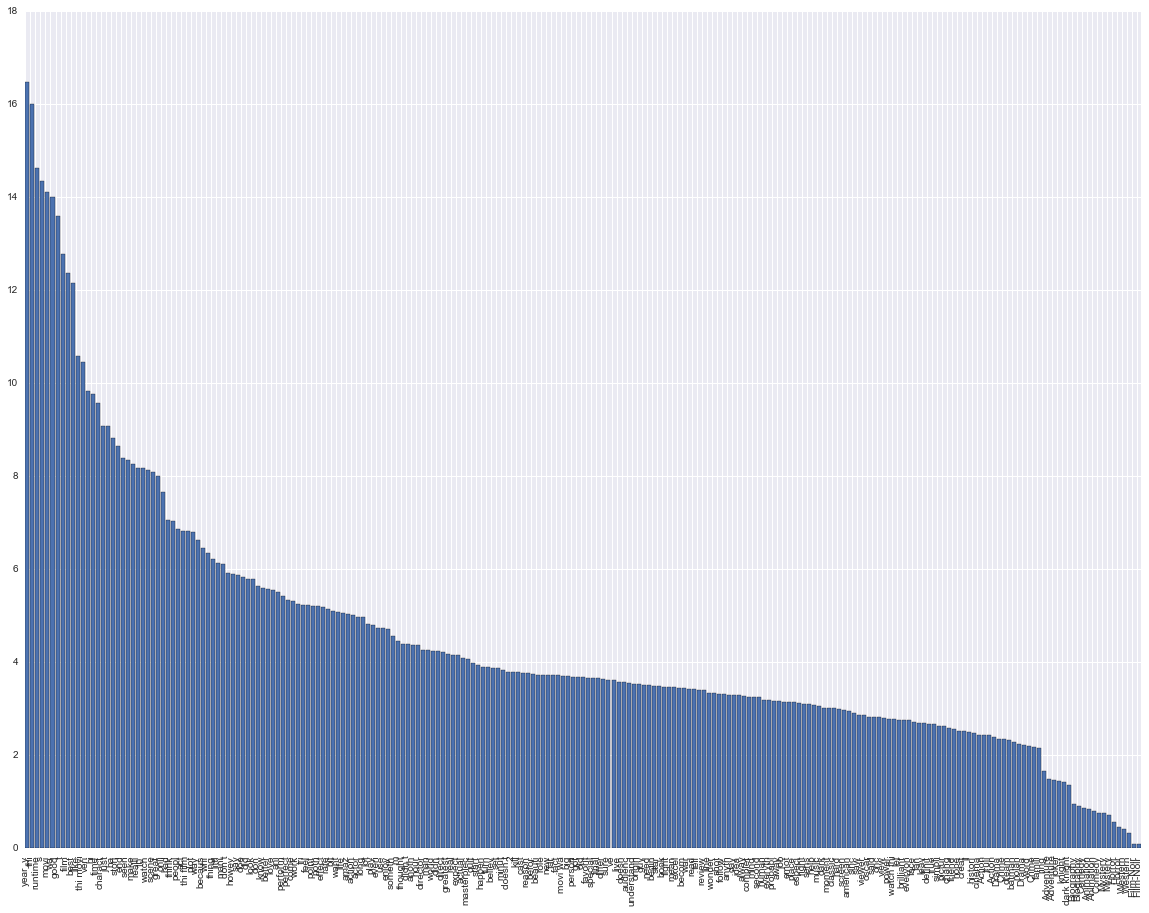

In [104]:
x_plot = range(len(importance['Features']))
plt.figure(figsize = (20, 15))
plt.xticks(x_plot, importance['Features'], rotation = 90)

plt.bar(x_plot, importance['model_importance (multiplied by 1000)'])
plt.show()